In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/kaggle/input/recursion-cellular-image-classification/"))

# Any results you write to the current directory are saved as output.
from pathlib import Path
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

BASE_DIR = Path('/kaggle/input/recursion-cellular-image-classification/')
CHANNELS = [1, 2, 3, 4, 5, 6]
SITES = [1, 2]
RGB_MAP = {
    1: {
        'rgb': np.array([19, 0, 249]),
        'range': [0, 51]
    },
    2: {
        'rgb': np.array([42, 255, 31]),
        'range': [0, 107]
    },
    3: {
        'rgb': np.array([255, 0, 25]),
        'range': [0, 64]
    },
    4: {
        'rgb': np.array([45, 255, 252]),
        'range': [0, 191]
    },
    5: {
        'rgb': np.array([250, 0, 253]),
        'range': [0, 89]
    },
    6: {
        'rgb': np.array([254, 255, 40]),
        'range': [0, 191]
    }
}

train_meta = pd.read_csv('/kaggle/input/recursion-cellular-image-classification/train.csv')
test_meta = pd.read_csv('/kaggle/input/recursion-cellular-image-classification/test.csv')
train_meta['well_type'] = 'treatment'
test_meta['sirna'] = None
test_meta['well_type'] = 'treatment'
train_controls = pd.read_csv('/kaggle/input/recursion-cellular-image-classification/train_controls.csv')
test_controls = pd.read_csv('/kaggle/input/recursion-cellular-image-classification/test_controls.csv')
common_controls = [1108, 1109, 1115, 1116, 1117, 1121, 1123, 1124, 1125, 1126, 1128, 1129, 1131, 1134, 1135, 1136, 1137, 1138]
train_meta = pd.concat([train_meta, train_controls])
test_meta = pd.concat([test_meta, test_controls])

print(train_meta.shape, test_meta.shape, train_controls.shape, test_controls.shape)

NUM_WELL_ROWS = 24
NUM_WELL_COLS = 16

['sample_submission.csv', 'pixel_stats.csv', 'train_controls.csv', 'test_controls.csv', 'train.csv', 'test.csv', 'recursion_dataset_license.pdf', 'test', 'train']
(40614, 6) (22145, 6) (4097, 6) (2246, 6)


In [13]:
def load_image_tensor(experiment, plate, well, site, channels=CHANNELS):
    if os.path.exists(BASE_DIR / 'train' / experiment):
        # It is from train.
        d = BASE_DIR / 'train' / experiment / f'Plate{plate}'
    else:
        # It is from test.
        d = BASE_DIR / 'test' / experiment / f'Plate{plate}'

    img_channels = []
    for channel in channels:
        path = d / f'{well}_s{site}_w{channel}.png'
        img_channels.append(np.array(Image.open(path)))
    
    return np.array(img_channels).transpose(1, 2, 0)

In [14]:
# Copied from
# https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/io.py
def convert_tensor_to_rgb(t, channels=CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, i] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(512, 512, 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    return im

In [15]:
def visualize(experiment, plate, well, site, channels=CHANNELS, ax=None):
    img_tensor = load_image_tensor(experiment, plate, well, site, channels)
    img = convert_tensor_to_rgb(img_tensor, channels=channels)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.set_axis_off()
    return img

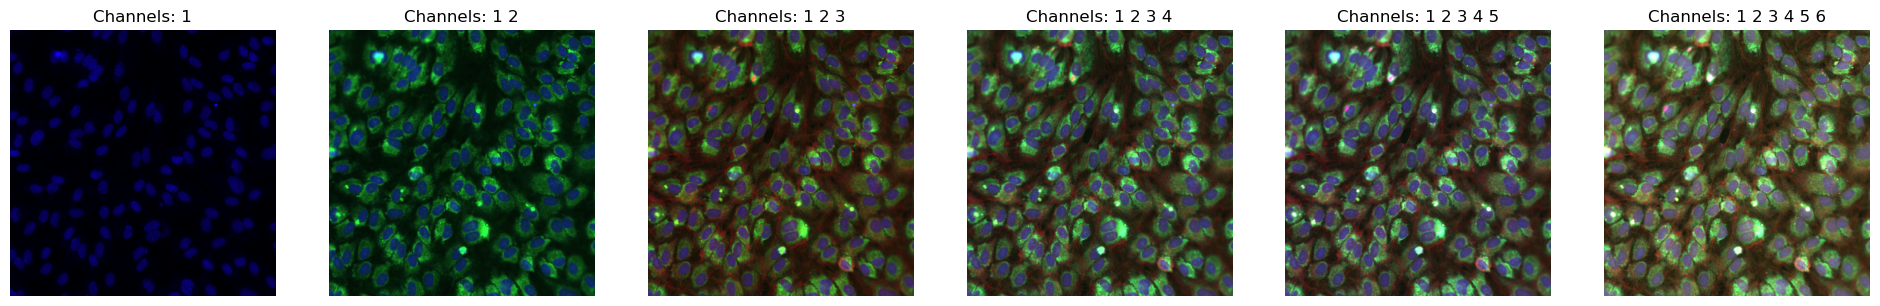

In [16]:
well_width = 24

fig = plt.figure(figsize=(well_width*1, well_width*6))
channels = []
for i in range(1, 7):
    ax = fig.add_subplot(1, 6, i)
    channels.append(i)
    ax.set_title('Channels: ' + ' '.join(map(str, channels)))
    visualize('HUVEC-01', 1, 'B02', 1, channels=channels, ax=ax);

**Visualization of pseudo-plate.**********
Here we reconstruct and visualize plates in-silico. For that, we have to map a (0-based) coordinate of a well in a 384-well (16 x 24) plate to a well ID.

Across well IDs, there are 14 kinds of alphabets (B~O) and 22 kinds of numbers (02~23). With that information, we can make a lookup table!

In [17]:
well2coord = dict()
for row, num in enumerate(range(1, 25)):  # We include outer rows and columns which were excluded due to the environmental effect here.
    for col, alphabet in enumerate('ABCDEFGHIJKLMNOP'):
        is_valid = (1 <= row <= 22) and (1 <= col <= 14)
        well2coord[f'{alphabet}{num:02}'] = (row, col, is_valid)

# Hold inverse mapping as well.
coord2well = {(r, c):w for w, (r, c, v) in well2coord.items()}

def is_valid_well(well):
    return well2coord[well][2]

In [18]:
def get_sirna(experiment, plate, well):
    mask = (train_meta.experiment == experiment) & (train_meta.plate == plate) & (train_meta.well == well)
    return train_meta[mask].sirna.values[0], train_meta[mask].well_type.values[0]

In [19]:
def show_pseudoplate(experiment, plate, site=1, channels=CHANNELS):
    # Figure aesthetics.
    well_size = 10
    
    # Plotting.
    fig = plt.figure(figsize=(NUM_WELL_COLS * well_size, NUM_WELL_ROWS * well_size))

    for row in tqdm_notebook(range(NUM_WELL_ROWS), desc='row'):
        for col in range(NUM_WELL_COLS):
            well = coord2well[(row, col)]
            if not is_valid_well(well):
                continue
            ax = fig.add_subplot(NUM_WELL_ROWS, NUM_WELL_COLS, row * NUM_WELL_COLS + (col + 1))
            sirna, well_type = get_sirna(experiment, plate, well)
            ax.set_title(f'{sirna} ({well_type})')
            ax.set_axis_off()
            visualize(experiment, plate, well, site=site, channels=channels, ax=ax)

In [ ]:
show_pseudoplate('HUVEC-01', 1)

/tmp/ipykernel_29/2198424213.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(range(NUM_WELL_ROWS), desc='row'):


row:   0%|          | 0/24 [00:00<?, ?it/s]

**Visualizing all the controls.**
Are there any apparent commonalities of cells treated with control siRNAs?

First, let's see how the controls are distributed throughout the plate

In [29]:
def show_controls(experiment, plate, ax):
    controls = train_meta[(train_meta.experiment == experiment) & (train_meta.plate == plate) & (train_meta.well_type.str.contains('control'))]

    for i, row in controls.iterrows():
        y, x, _ = well2coord[row.well]
        color = 'red' if row.well_type == 'positive_control' else 'blue'
        ax.scatter(x, NUM_WELL_ROWS - y, c=color)
    ax.set_xlim([0, NUM_WELL_COLS])
    ax.set_ylim([0, NUM_WELL_ROWS])
    ax.set_aspect('equal')

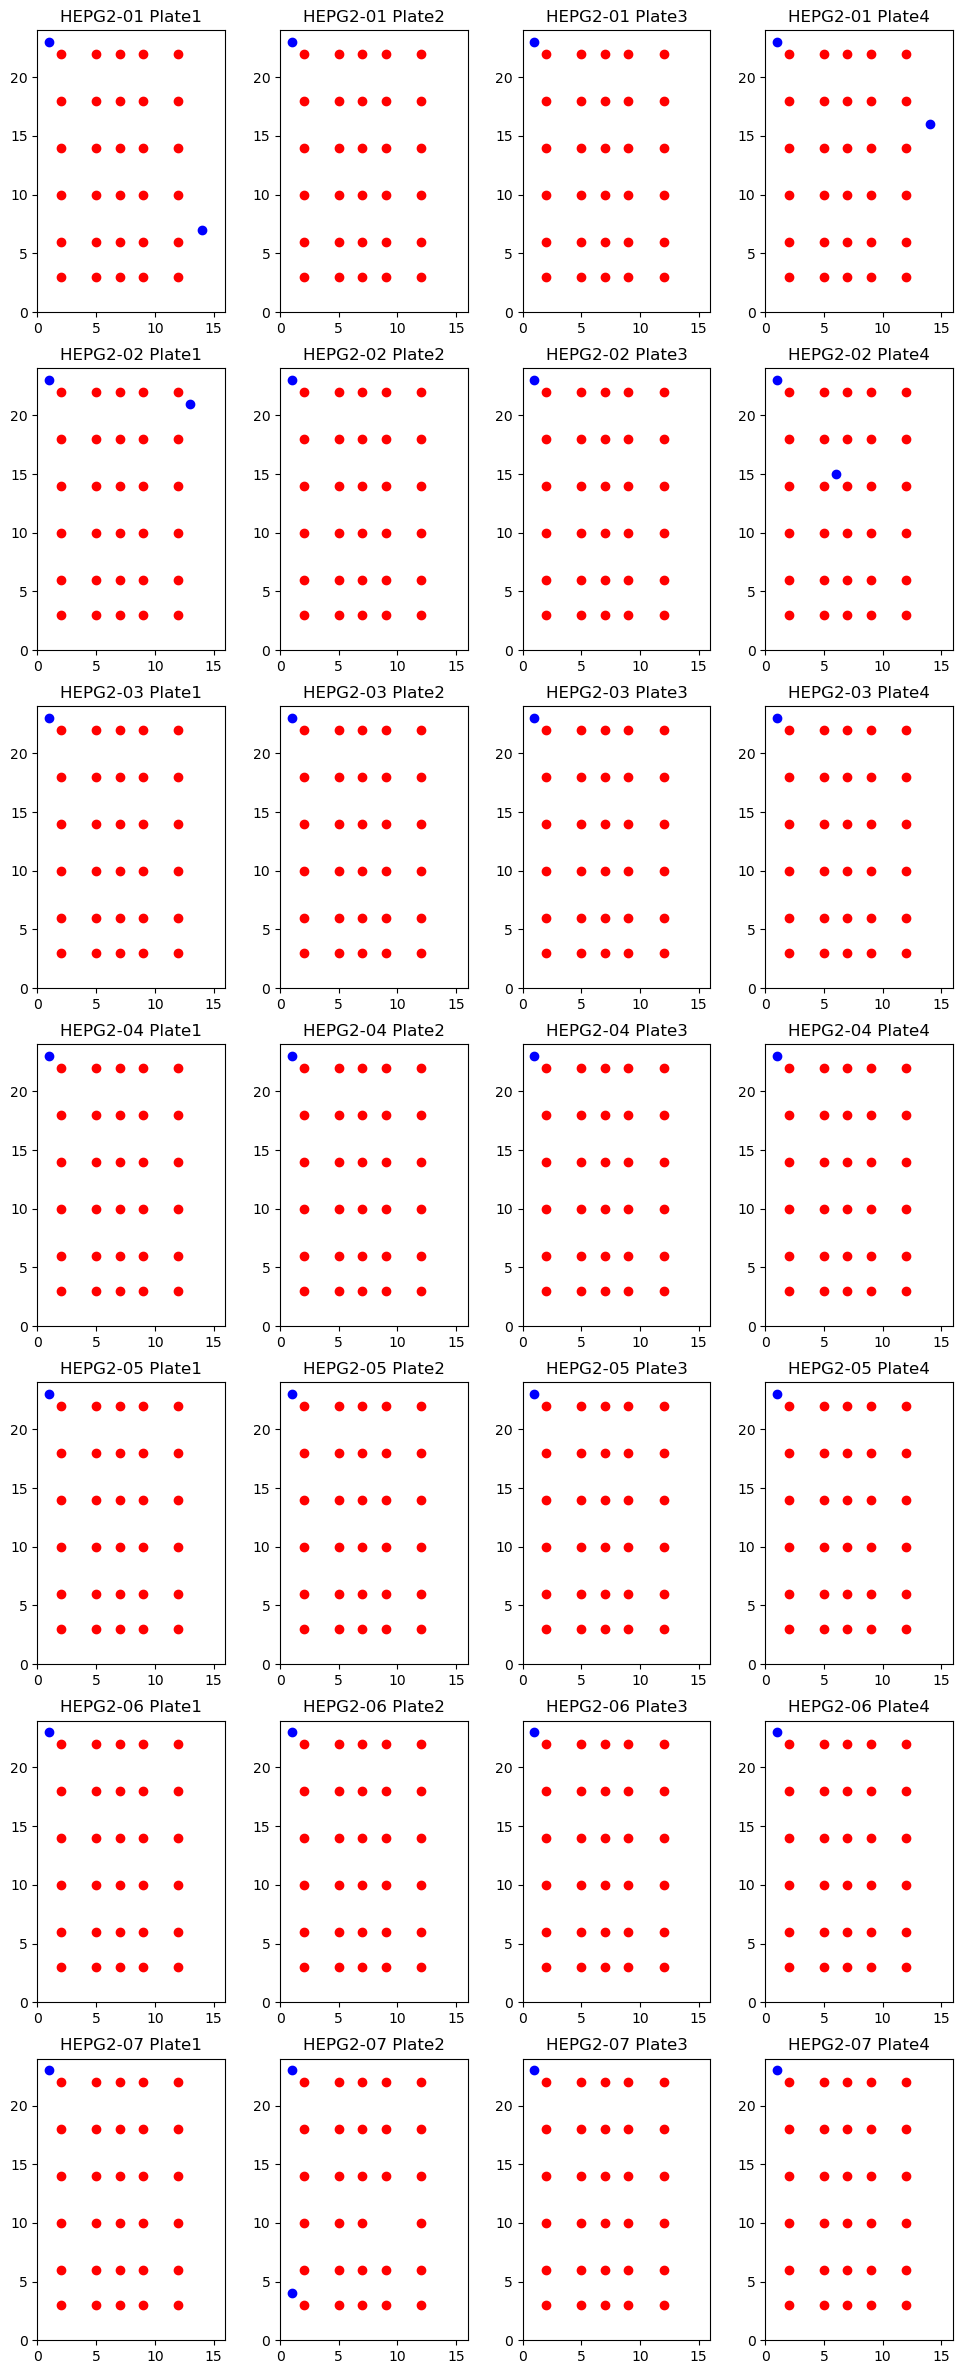

In [30]:
fig = plt.figure(figsize=(12, 30))

num_experiments = 7
for experiment in range(1, num_experiments + 1):
    exp = f'HEPG2-{experiment:02}'
    for plate in range(1, 5):
        ax = fig.add_subplot(num_experiments, 4, (experiment - 1) * 4 + plate)
        ax.set_title(f'{exp} Plate{plate}')
        show_controls(experiment=exp, plate=plate, ax=ax)

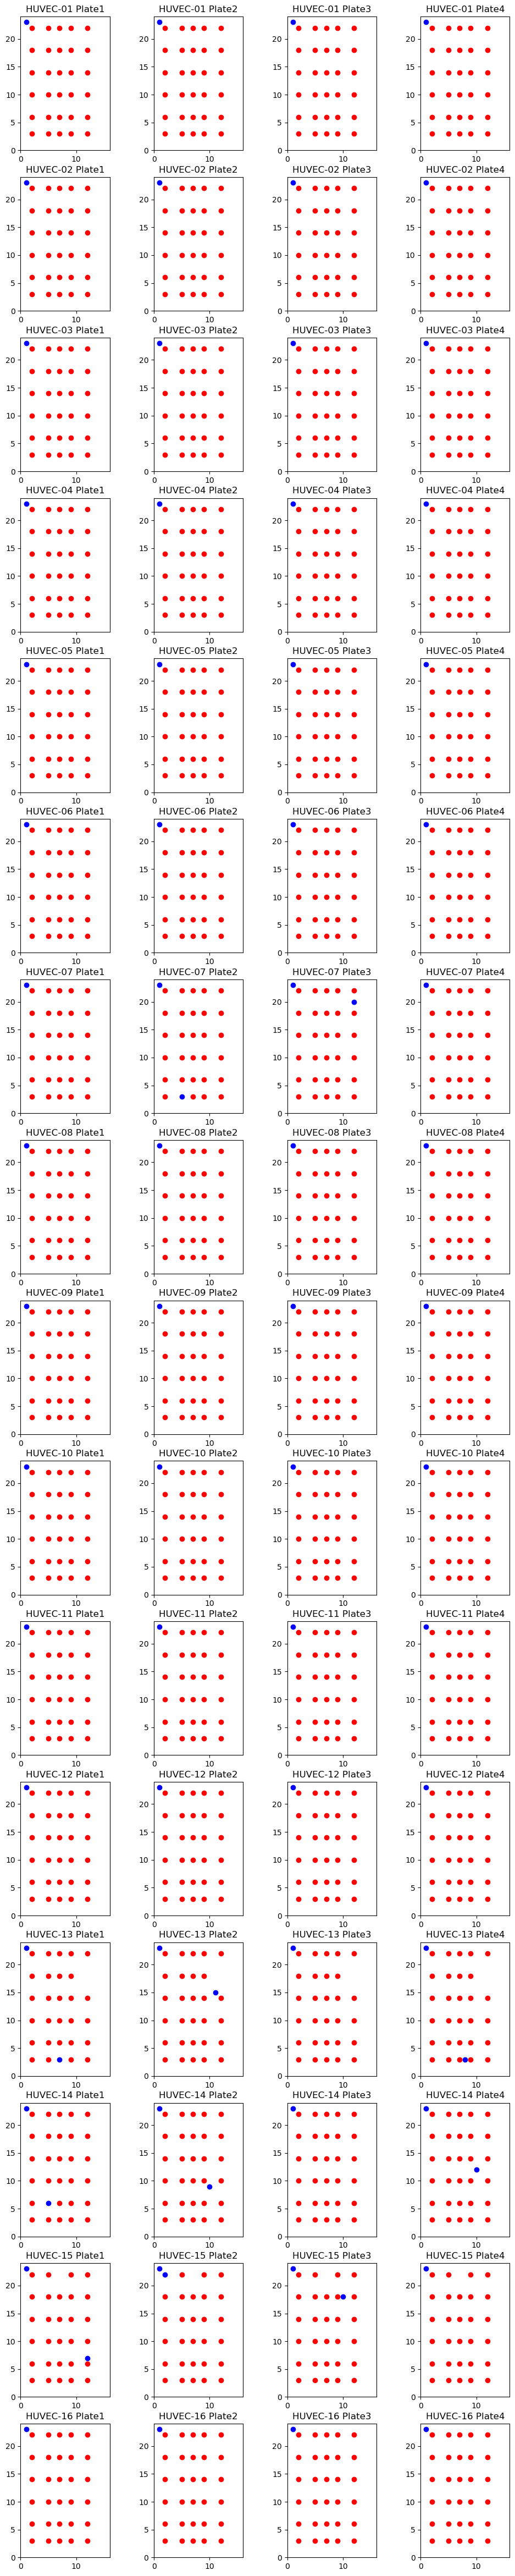

In [31]:
fig = plt.figure(figsize=(12, 60))

num_experiments = 16
for experiment in range(1, num_experiments + 1):
    exp = f'HUVEC-{experiment:02}'
    for plate in range(1, 5):
        ax = fig.add_subplot(num_experiments, 4, (experiment - 1) * 4 + plate)
        ax.set_title(f'{exp} Plate{plate}')
        show_controls(experiment=exp, plate=plate, ax=ax)

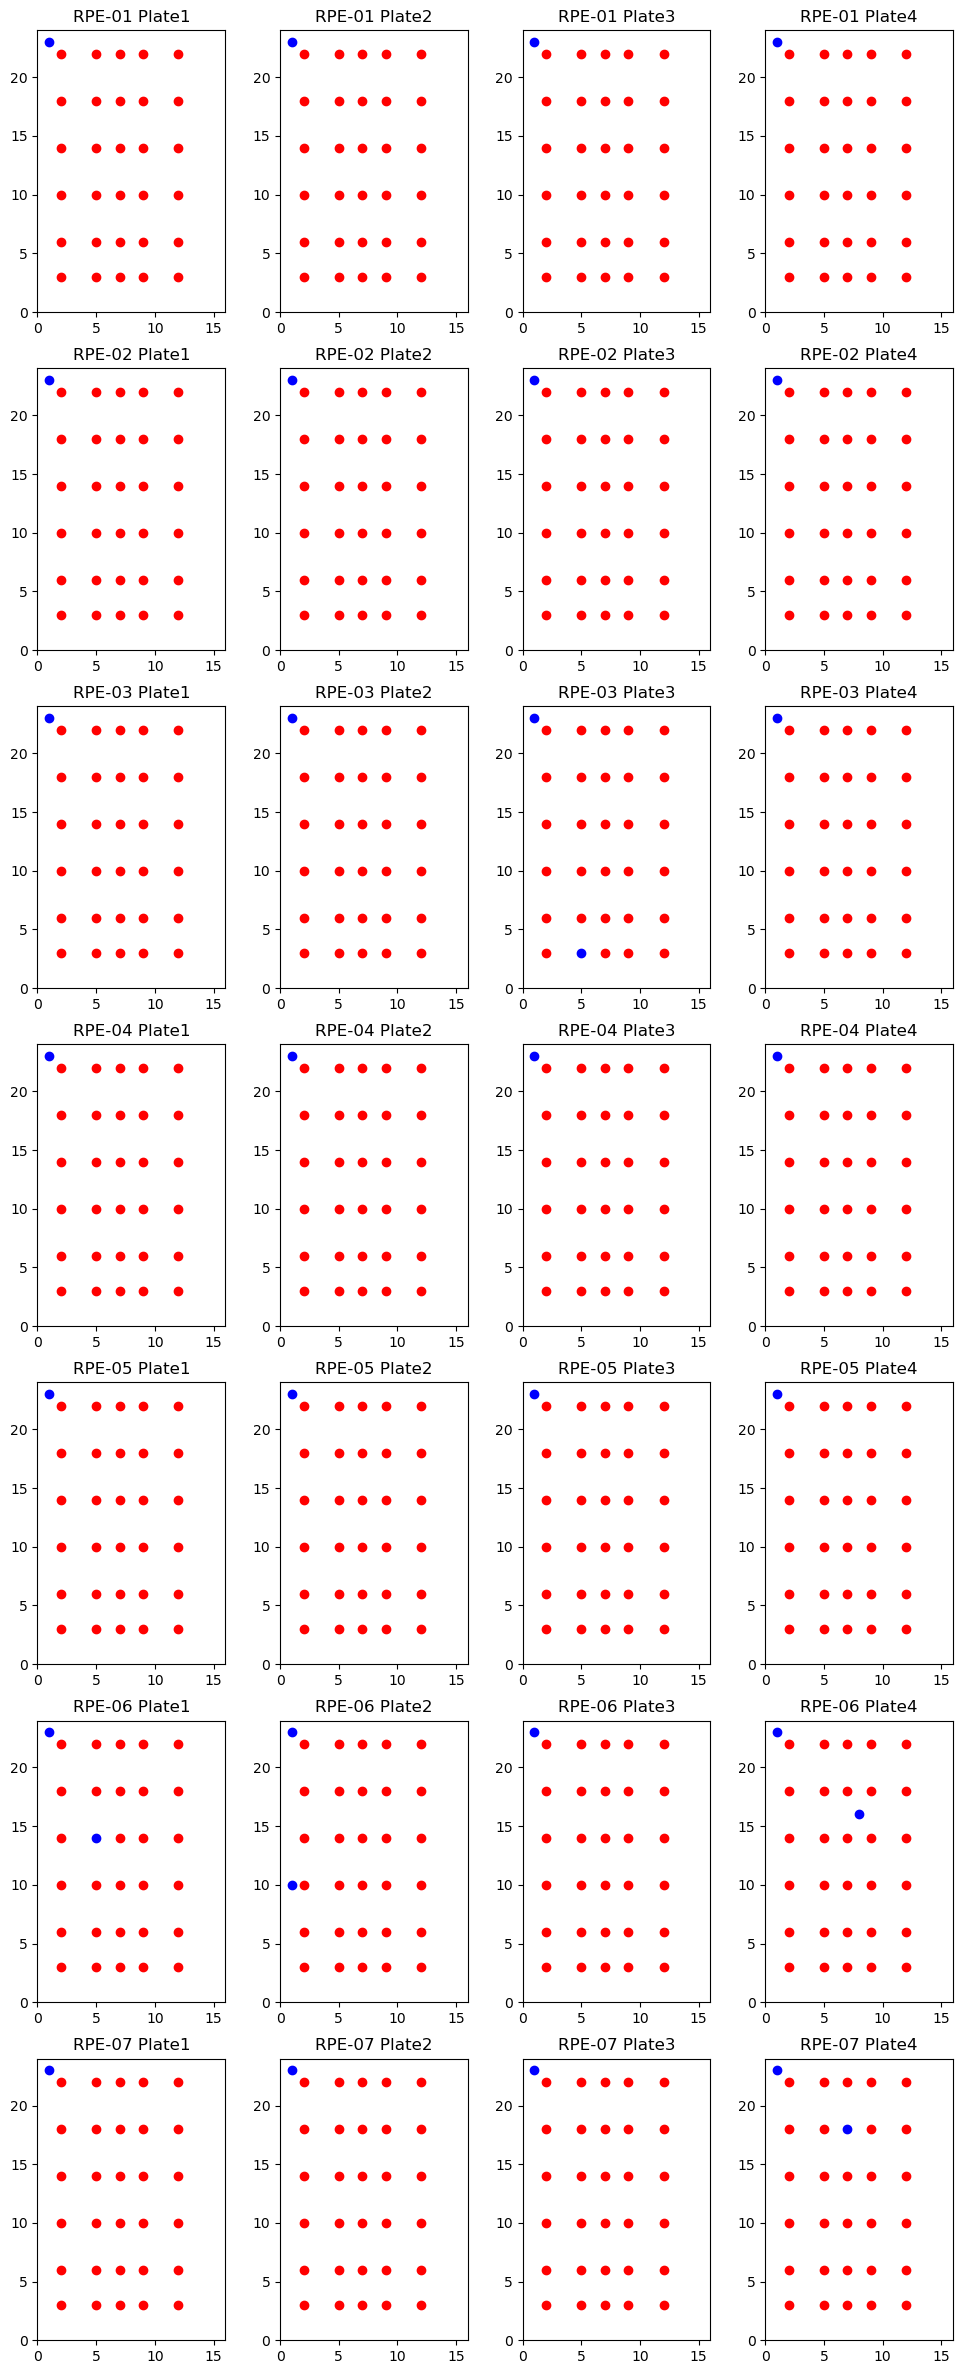

In [32]:
fig = plt.figure(figsize=(12, 30))

num_experiments = 7
for experiment in range(1, num_experiments + 1):
    exp = f'RPE-{experiment:02}'
    for plate in range(1, 5):
        ax = fig.add_subplot(num_experiments, 4, (experiment - 1) * 4 + plate)
        ax.set_title(f'{exp} Plate{plate}')
        show_controls(experiment=exp, plate=plate, ax=ax)

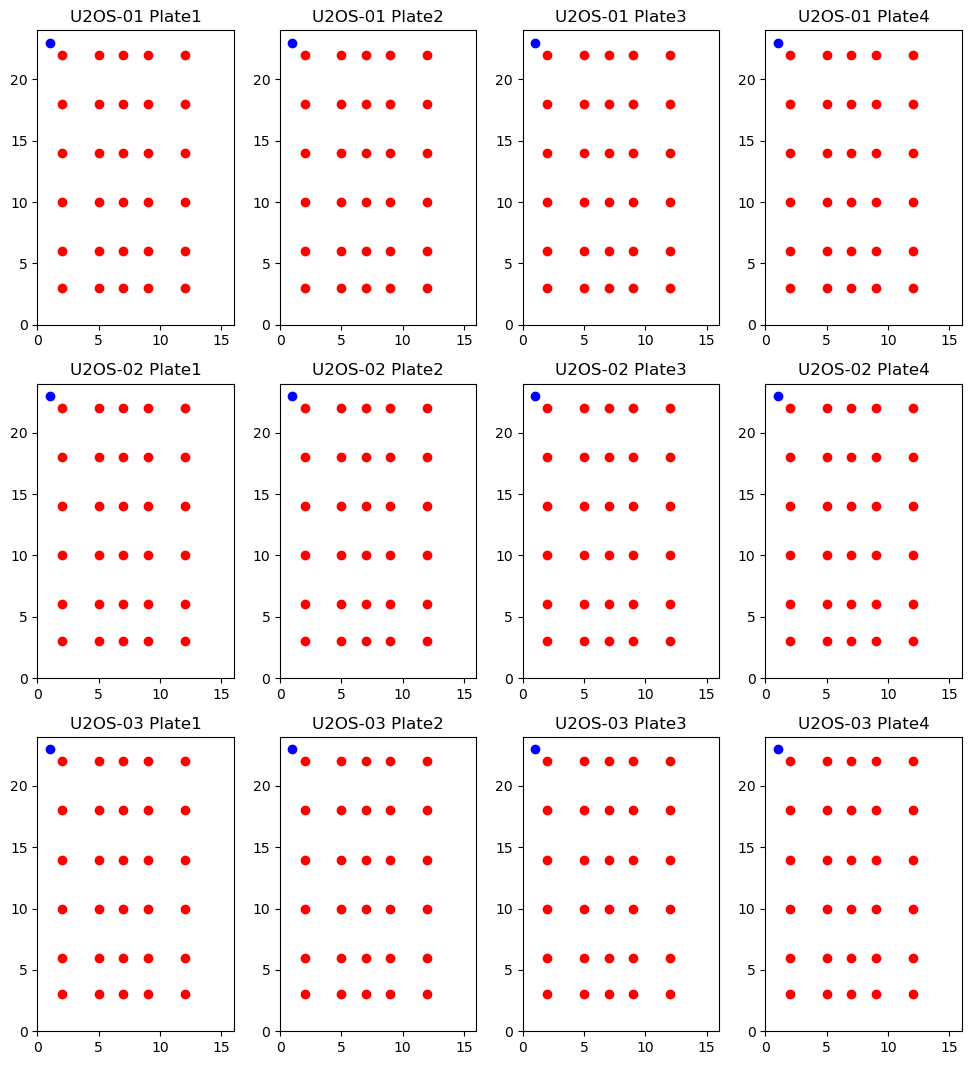

In [33]:
fig = plt.figure(figsize=(12, 13))

num_experiments = 3
for experiment in range(1, num_experiments + 1):
    exp = f'U2OS-{experiment:02}'
    for plate in range(1, 5):
        ax = fig.add_subplot(num_experiments, 4, (experiment - 1) * 4 + plate)
        ax.set_title(f'{exp} Plate{plate}')
        show_controls(experiment=exp, plate=plate, ax=ax)

Some plates have got additional negative controls (such as RPE-06 Plate 2), missing positive controls (such as HUVEC-13 Plate 4). But generally all the controls are seemingly at identical positions.

**Visualizing positive control siRNA-treated cell images.**
Let's compare images of cells that are treated with positive control siRNAs with nontreated cell lines (negative controls).

In [63]:
def get_well_with_sirna(experiment, plate, sirna):
    mask = (train_meta.experiment == experiment) & (train_meta.plate == plate) & (train_meta.sirna == sirna)
    matching_wells = train_meta[mask].well.values
    if len(matching_wells) > 0:
        return matching_wells[-1]
    else:
        raise ValueError("No matching well found for the given experiment, plate, and sirna.")


In [64]:
def visualize_cells_with_sirna(experiment, sirna, channels=CHANNELS):
    well_size = 10
    title_fs = 20

    fig = plt.figure(figsize=(4*well_size, 2*well_size))
    experiment = experiment
    negative_sirna = 1108
    positive_sirna = sirna

    for plate in range(1, 5):
        ax1 = fig.add_subplot(2, 4, plate)
        ax2 = fig.add_subplot(2, 4, 4 + plate)

        neg_well = get_well_with_sirna(experiment, plate, negative_sirna)
        pos_well = get_well_with_sirna(experiment, plate, positive_sirna)

        visualize(experiment, plate, neg_well, site=1, channels=channels, ax=ax1)
        visualize(experiment, plate, pos_well, site=1, channels=channels, ax=ax2)
        ax1.set_title(f'{experiment} Plate{plate}, negative control', fontdict={'fontsize': title_fs})
        ax2.set_title(f'{experiment} Plate{plate}, siRNA {positive_sirna}', fontdict={'fontsize': title_fs})

As an example, lets visualize cells treated with siRNA 1109 along with untreated cells.

ValueError: No matching well found for the given experiment, plate, and sirna.

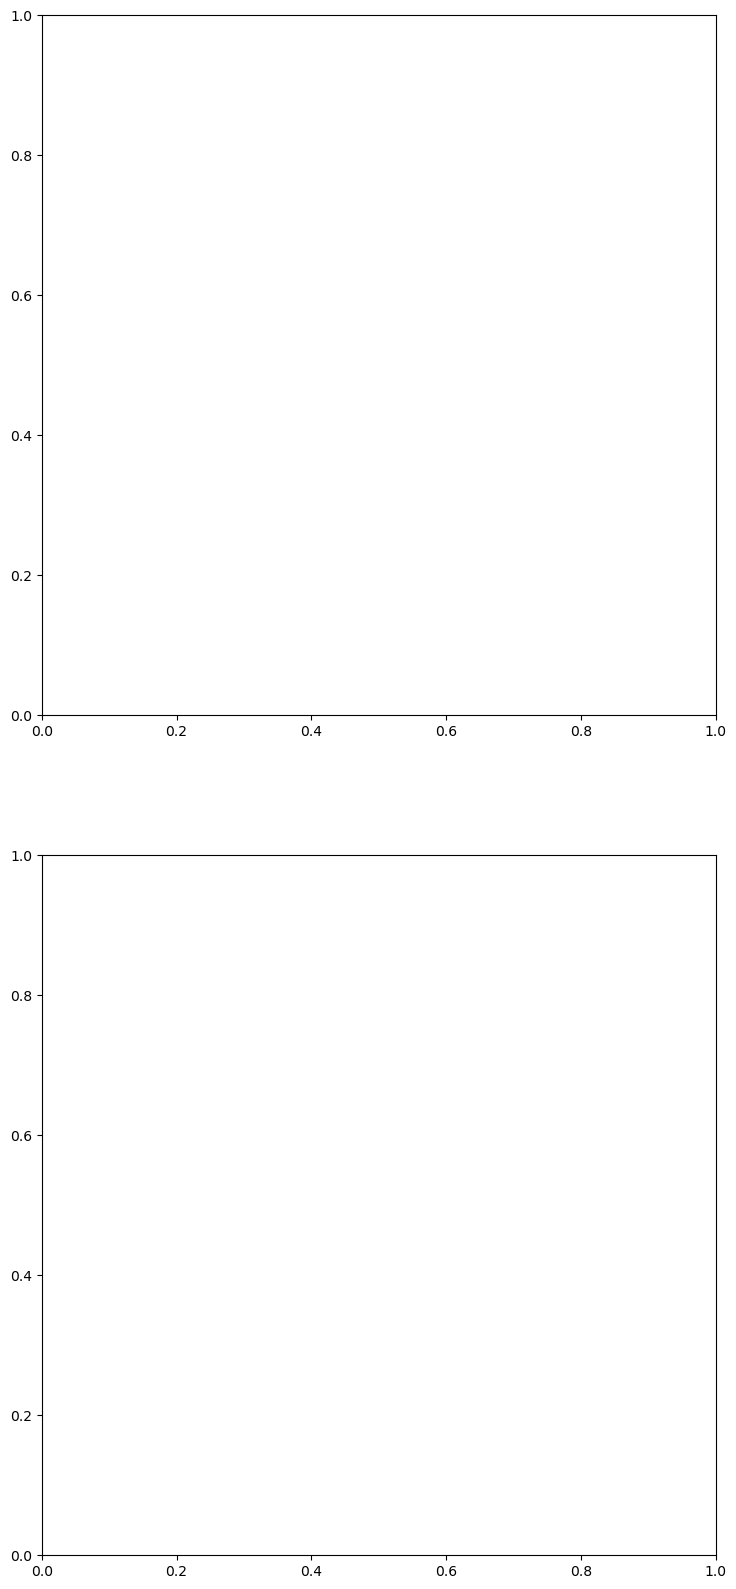

In [65]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[1])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/recursion-cellular-image-classification/train/HUVEC-01/Plate1/None_s1_w2.png'

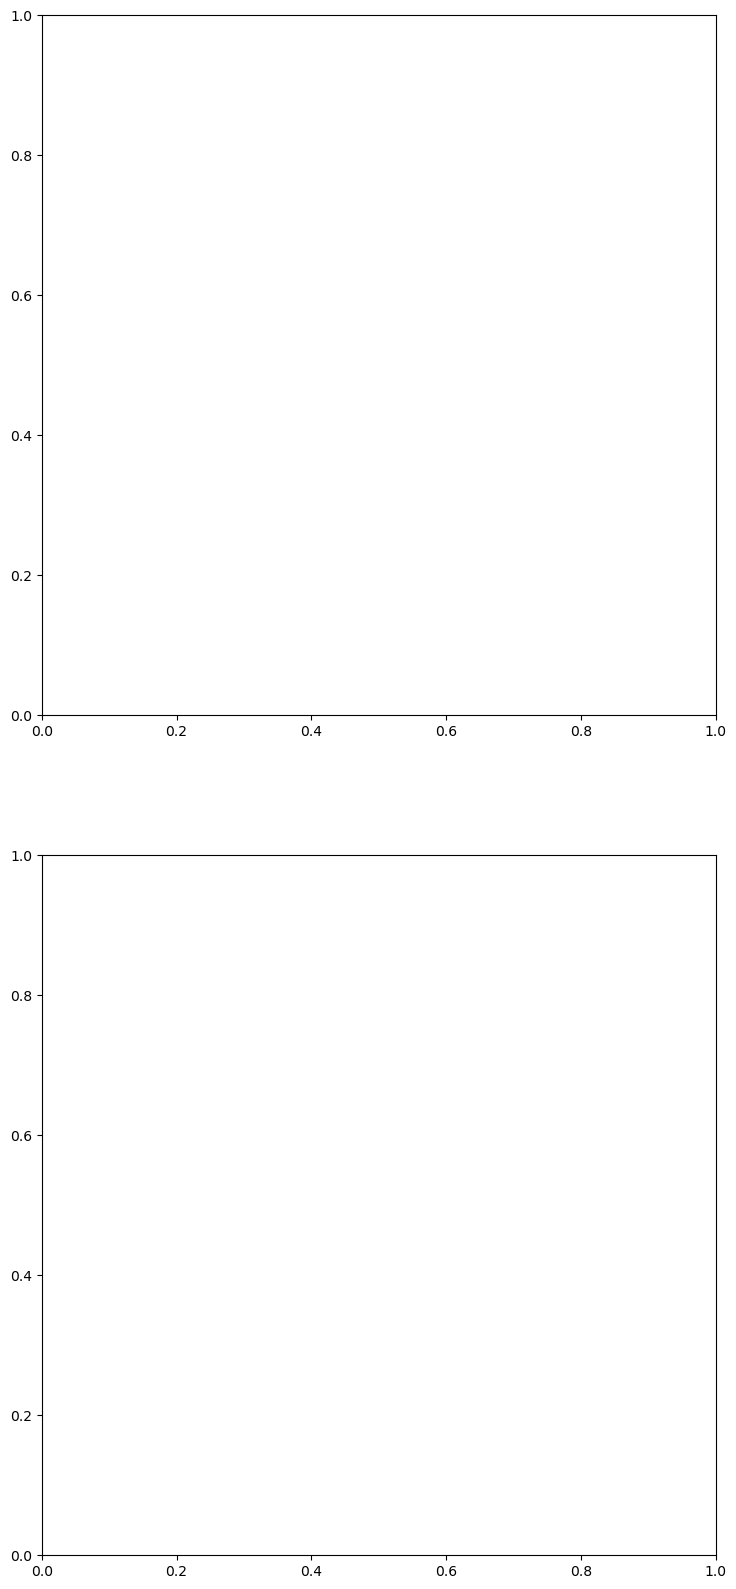

In [37]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[2])

In [ ]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[3])

In [ ]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[4])

ValueError: No matching well found for the given experiment, plate, and sirna.

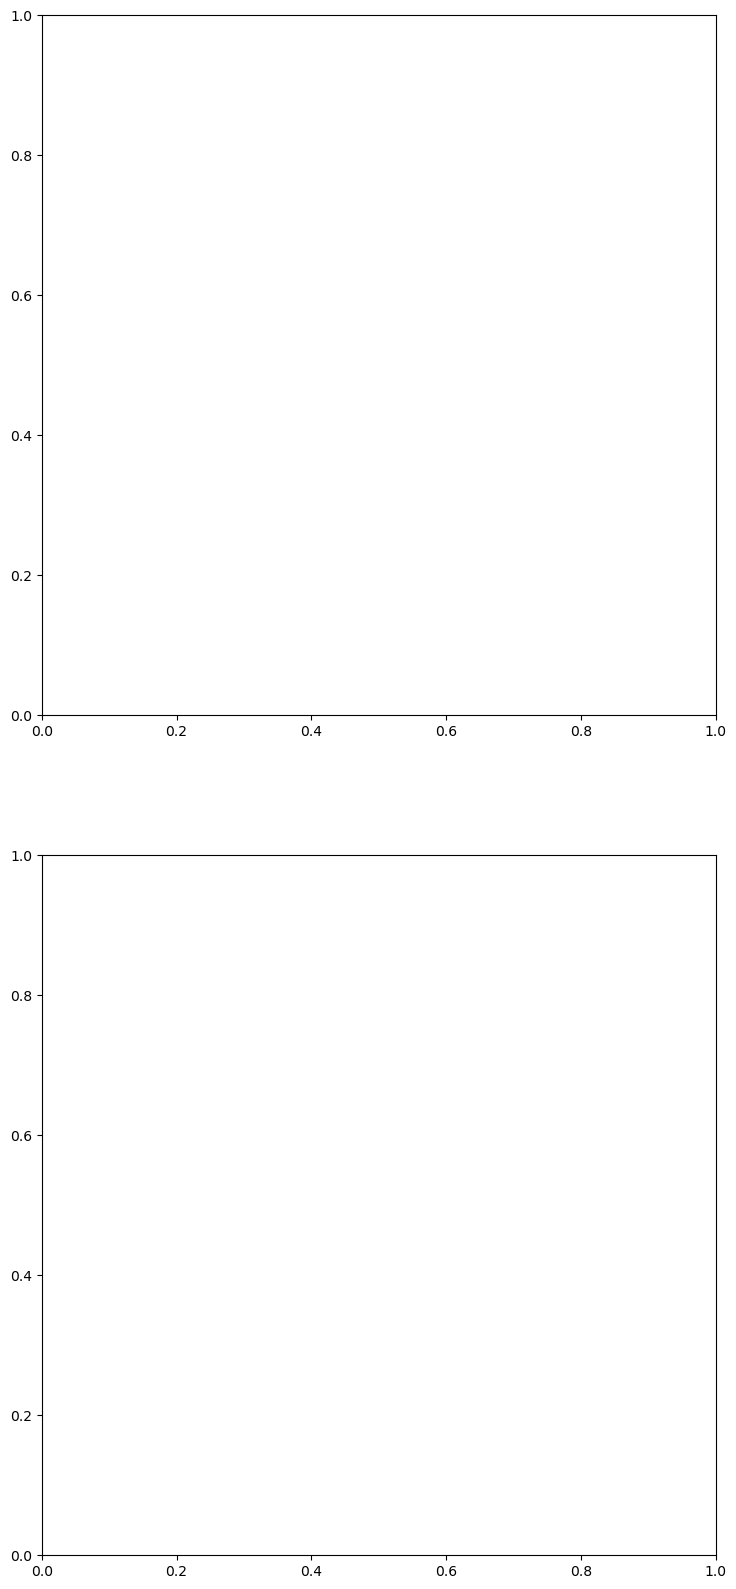

In [66]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[5])

In [ ]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[6])

In [ ]:
visualize_cells_with_sirna('HUVEC-01', 1109, channels=[1, 2, 3, 4, 5, 6])

In [ ]:
visualize_cells_with_sirna('HUVEC-02', 1109)

In [ ]:
visualize_cells_with_sirna('HUVEC-03', 1109)

In [ ]:
visualize_cells_with_sirna('HEPG2-01', 1109)

In [ ]:
visualize_cells_with_sirna('HEPG2-02', 1109)

In [ ]:
visualize_cells_with_sirna('HEPG2-03', 1109)

In [ ]:
visualize_cells_with_sirna('RPE-01', 1109)

ValueError: No matching well found for the given experiment, plate, and sirna.

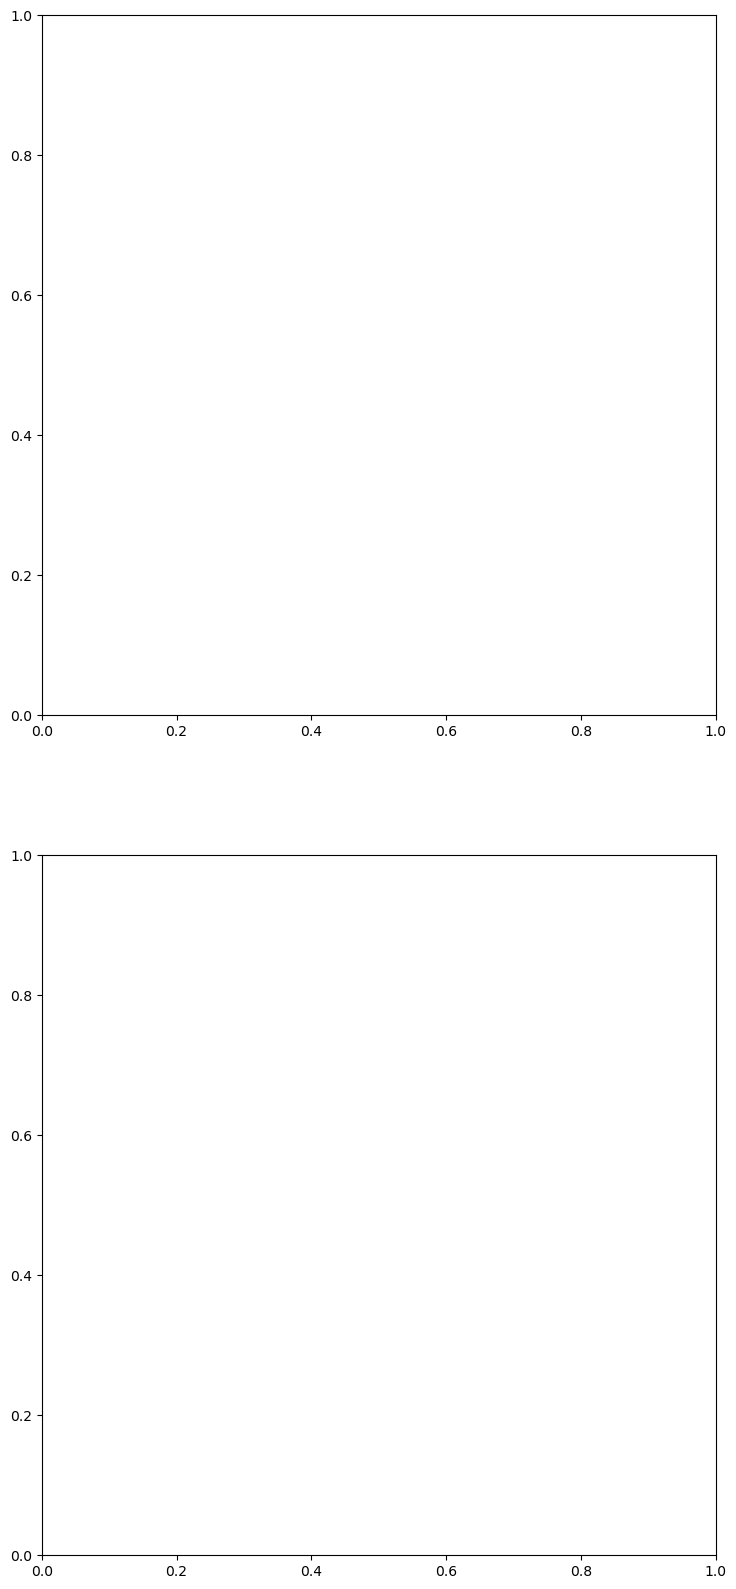

In [67]:
visualize_cells_with_sirna('RPE-02', 1109)

In [ ]:
visualize_cells_with_sirna('RPE-03', 1109)

In [ ]:
visualize_cells_with_sirna('U2OS-01', 1109)

In [ ]:
visualize_cells_with_sirna('U2OS-02', 1109)

ValueError: No matching well found for the given experiment, plate, and sirna.

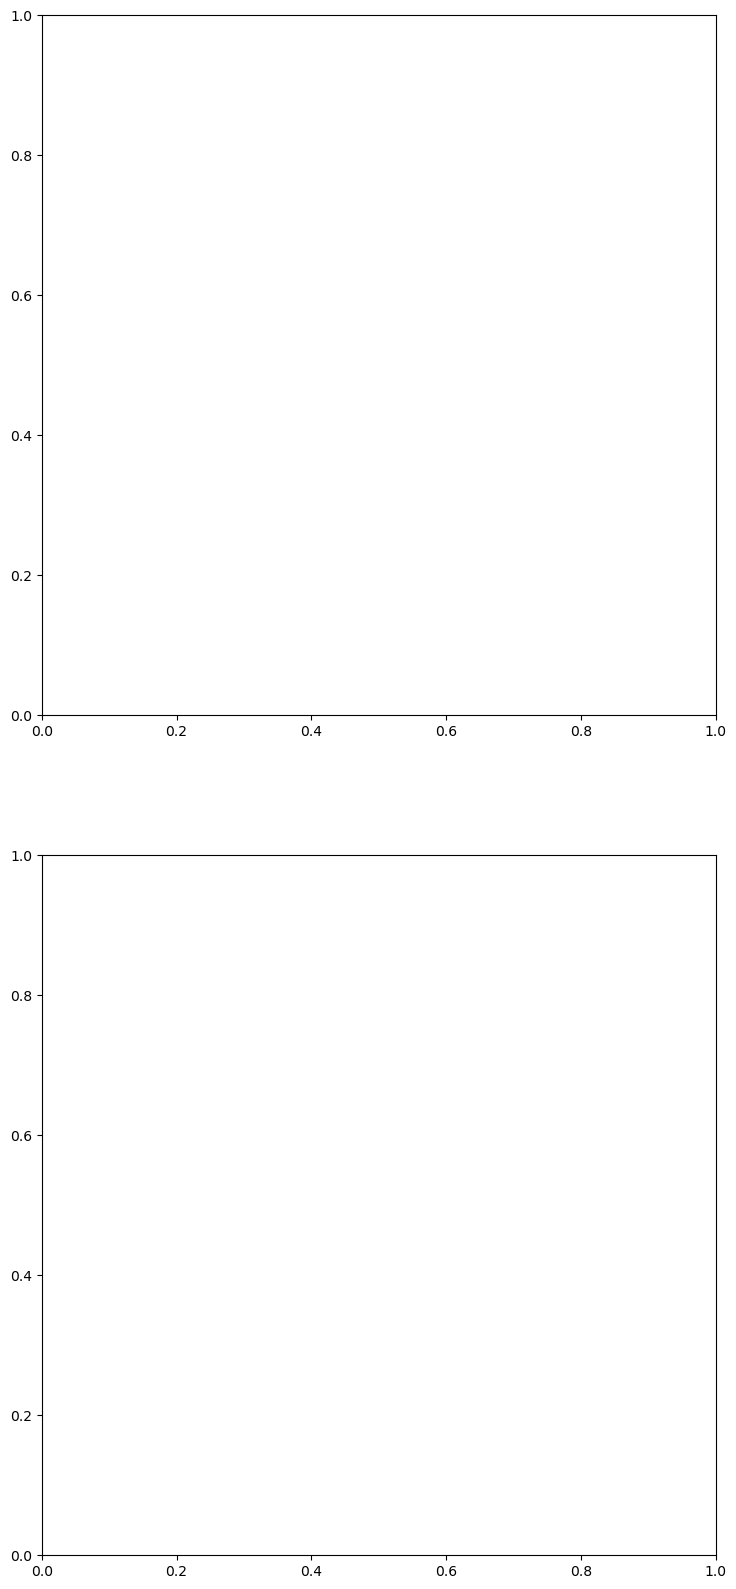

In [68]:
visualize_cells_with_sirna('U2OS-03', 1109)